## Quantum Layers Application

In [11]:
#Import the required modules
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split


## Convolutional Layers

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(a[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(a[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(a[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     ├──────────┤└────┬────┘└────┬────┘                      
q_3: ┤ Rx(a[3]) ├─────■──────────■───────────────────────────
     └──────────┘                                            


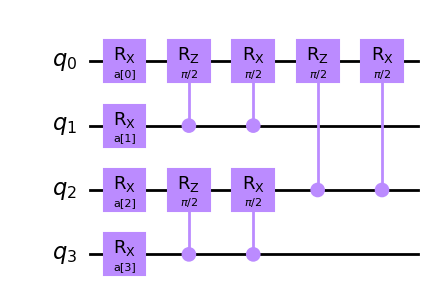

In [19]:
def conv_circuit(params):
    target = QuantumCircuit(4)
    #Apply the Rx gate with given parameteres
    for i in range(len(params)):
        target.rx(params[i],i)
    #Assuming that the gates without the angle are rotated by pi/2
    target.crz(np.pi / 2, 1, 0)
    target.crx(np.pi / 2, 1, 0)
    target.crz(np.pi/2, 3, 2) #Apply controlled Rz to 3rd and 4
    target.crx(np.pi/2 , 3, 2)
    target.crz(np.pi/2 , 2, 0)
    target.crx(np.pi/2, 2, 0 )
    print(target)
    return target

params = ParameterVector("a",length = 4)
circuit = conv_circuit(params)
circuit.draw("mpl")

    
    

## Pooling Layers

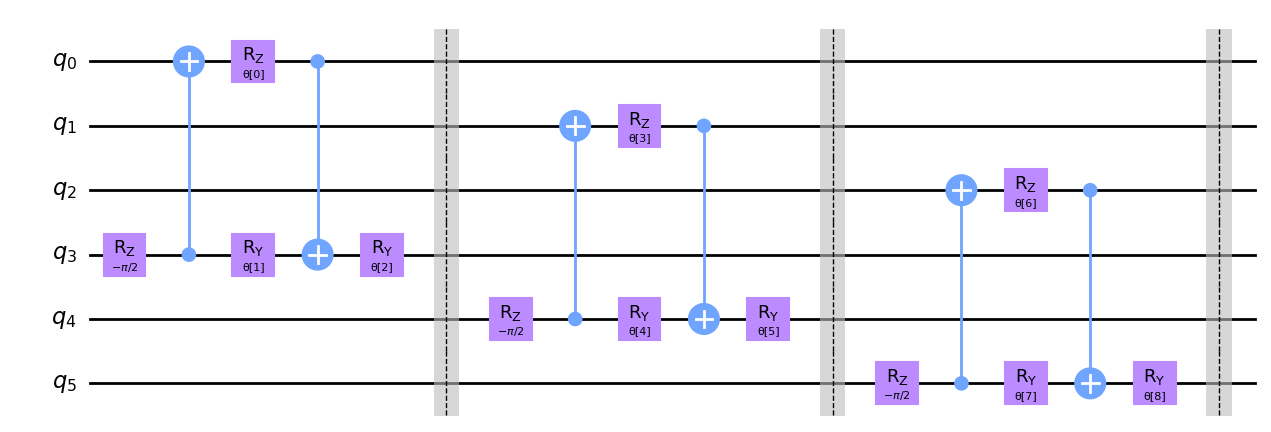

In [10]:

#Defining a single pooling layer
def pooling_circuit(params) :
    target = QuantumCircuit(2)          #We are defining a quantum circuit with 2 qubits
    target.rz(-np.pi / 2,1)             #Applying the Rz gate to the qubit at position 1
    target.cx(1,0)                      #Apply CNOT gate with second qubit as control and first qubit as control
    target.rz(params[0], 0)             #Apply a rotation angle stored in params[0] to qubit in position 0
    target.ry(params[1],1)
    target.cx(0,1)
    target.ry(params[2],1)

    return target

#Define the layer  for a larger number of qubits
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks) #The number of qubits is equal to the total number of sources and sinks. Sources are original qubits and sinks are qubits after pooling
    qc = QuantumCircuit(num_qubits, name = "Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length = num_qubits // 2*3) #We divide num_qubits by 2 as we need a parameter vector for each pair of source and sinks. 
    # The number of paramters is 3 as we use the 3 of them in the pooling_circuit code. The params array contain a rotation angle for X, Y and Z axis. Hence size is 3

    for source, sink in zip(sources, sinks):
        qc = qc.compose(pooling_circuit(params[param_index : (param_index + 3)]), [source, sink]) #The first three parameters are sent to compose the circuit on the source and sink
        qc.barrier()
        param_index+=3 #Switch to the next set of 3 parameters after first layer
    
    qc_inst = qc.to_instruction() #Convert the quantum circuit into a single instruction to add to other circuits
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc # Return the quantum circuit


sources = [0,1, 2]
sinks = [3, 4,5]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")